In [1]:
from solver import solve
from pprint import pprint

from random import uniform, randint

from matplotlib import pyplot as plt

In [2]:
def generate_problem(variables, constraint_probability, max_intervals):
    X = [0] + [randint(0, 100) for _ in range(variables-1)]    
    T_all = []

    visited_edges = set()    

    for j in range(variables):
        T = {
            'i': 0,
            'j': j,
            'intervals': [(-100, 100)],
        }
        T_all += [T]
        
    for i in range(1, variables):
        for j in range(i+1, variables):
            if uniform(0, 1) < constraint_probability:
                T = {}
                diff = X[j] - X[i]
                T['i'] = i
                T['j'] = j
                T['intervals'] = []
                for _ in range(randint(1, max_intervals)):
                    m = randint(-100, 90)
                    T['intervals'].append( (m, m+10) )
                T_all.append(T)

    return T_all

def print_problem(T):
    print(max(cr['j'] for cr in T) + 1, len(T))
    for Tij in T:
        print(Tij['i'], Tij['j'], len(Tij['intervals']), end=' ')
        for a, b in Tij['intervals']:
            print(a, b, end=' ')
        print()

In [4]:
prob = generate_problem(10, 0.1, 4)
prob

[{'i': 0, 'j': 0, 'intervals': [(-100, 100)]},
 {'i': 0, 'j': 1, 'intervals': [(-100, 100)]},
 {'i': 0, 'j': 2, 'intervals': [(-100, 100)]},
 {'i': 0, 'j': 3, 'intervals': [(-100, 100)]},
 {'i': 0, 'j': 4, 'intervals': [(-100, 100)]},
 {'i': 0, 'j': 5, 'intervals': [(-100, 100)]},
 {'i': 0, 'j': 6, 'intervals': [(-100, 100)]},
 {'i': 0, 'j': 7, 'intervals': [(-100, 100)]},
 {'i': 0, 'j': 8, 'intervals': [(-100, 100)]},
 {'i': 0, 'j': 9, 'intervals': [(-100, 100)]},
 {'i': 2, 'j': 4, 'intervals': [(-57, -47), (-74, -64), (21, 31)]},
 {'i': 3, 'j': 5, 'intervals': [(72, 82), (55, 65), (-6, 4), (63, 73)]},
 {'i': 4, 'j': 7, 'intervals': [(-50, -40)]},
 {'i': 6, 'j': 9, 'intervals': [(62, 72), (-17, -7), (80, 90)]}]

In [5]:
def pick_first(constraints):
    return constraints[0]

def pick_least_intervals(constraints):
    sol_ctr = constraints[0]
    num = len(sol_ctr['intervals'])
    for ctr in constraints[1:]:
        if len(ctr['intervals']) < num:
            sol_ctr = ctr
            num = len(ctr['intervals'])
    
    return sol_ctr

print_problem(prob)
solve(10, prob, pick_first)

10 14
0 0 1 -100 100 
0 1 1 -100 100 
0 2 1 -100 100 
0 3 1 -100 100 
0 4 1 -100 100 
0 5 1 -100 100 
0 6 1 -100 100 
0 7 1 -100 100 
0 8 1 -100 100 
0 9 1 -100 100 
2 4 3 -57 -47 -74 -64 21 31 
3 5 4 72 82 55 65 -6 4 63 73 
4 7 1 -50 -40 
6 9 3 62 72 -17 -7 80 90 


{'consistent': 36, 'dead': 0, 'total': 113}

In [5]:
# what to graph:
# 1) graph how many have a consistent solution
# 2) dead end cuts
# 3) how likely is Path Consistency and/or Arc Consistency to find correct solution??
# 4) ^ continuation: does it find correct minimal network

In [6]:
def try_heuristic(runs, num_vars, constr_prob, max_intervals):
    consistent = 0
    
    dead = 0
    total = 0

    # least intervals heur.
    dead_li = 0
    total_li = 0
    
    for run in range(runs):
        print(run, end=" ")
        T = generate_problem(num_vars, constr_prob, max_intervals)

        sol = solve(num_vars, T, pick_constraint=pick_first)
        if sol['consistent'] > 0:
            consistent += 1
        dead += sol['dead']
        total += sol['total']

        sol_li = solve(num_vars, T, pick_constraint=pick_least_intervals)
        dead_li += sol_li['dead']
        total_li += sol_li['total']


    fig, axs = plt.subplots(2)
    axs[0].bar(
        ['consistent', 'inconsistent'],
        [consistent, runs - consistent],
    )

    axs[1].bar(
        ['dead ends', 'total ends', 'dead ends LI', 'total ends LI'],
        [dead / runs, total / runs, dead_li / runs, total_li / runs],
    )

0 1 2 3 4 5 6 7 8 9 

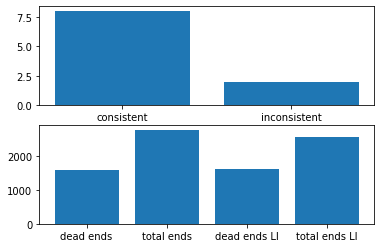

In [9]:
try_heuristic(
    runs=10,
    num_vars=8,
    constr_prob=0.3,
    max_intervals=5, 
)

0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 

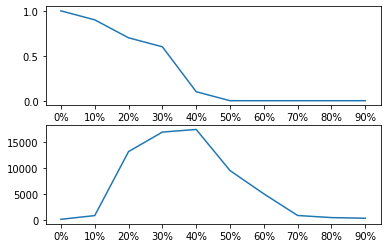

In [24]:
# percent satisfiable over constraint probability on everything else fixed
def try_sat(runs, num_vars, constr_prob, max_intervals):
    consistent = 0
    calls = 0
    
    for run in range(runs):
        print(run, end=" ")
        T = generate_problem(num_vars, constr_prob, max_intervals)
        sol = solve(num_vars, T, pick_constraint=pick_least_intervals)
        if sol['consistent'] > 0:
            consistent += 1
        calls += sol['total']
    
    return (consistent / runs, calls) 

x_axis = []
graph = []
calls = []
for prob in range(0, 100, 10):
    x_axis.append(f'{prob}%')
    sat, n_calls = try_sat(
        runs=10,
        num_vars=10,
        constr_prob=prob/100,
        max_intervals=5,
    )
    graph.append(sat)
    calls.append(n_calls)

fig, axs = plt.subplots(2)
axs[0].plot(x_axis, graph)
axs[1].plot(x_axis, calls)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

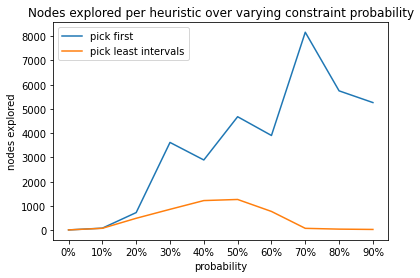

In [12]:
# percent satisfiable over constraint probability on everything else fixed
def try_heur(runs, num_vars, constr_prob, max_intervals):
    consistent = 0
    calls_first = 0
    calls_least = 0
    
    for run in range(runs):
        print(run, end=" ")
        T = generate_problem(num_vars, constr_prob, max_intervals)
        
        sol = solve(num_vars, T, pick_constraint=pick_first)
        calls_first += sol['total']
    
        sol = solve(num_vars, T, pick_constraint=pick_least_intervals)
        calls_least += sol['total']
    
    return calls_first / runs, calls_least / runs

x_axis = []
graph = []
calls_first = []
calls_least = []
for prob in range(0, 100, 10):
    x_axis.append(f'{prob}%')
    cf, cl = try_heur(
        runs=20,
        num_vars=9,
        constr_prob=prob/100,
        max_intervals=5,
    )
    calls_first.append(cf)
    calls_least.append(cl)

plt.plot(x_axis, calls_first, label="pick first")
plt.plot(x_axis, calls_least, label="pick least intervals")
plt.xlabel('probability')
plt.ylabel('nodes explored')
plt.title('Nodes explored per heuristic over varying constraint probability')
plt.legend()
plt.show()